In [1]:
# !pip install vowpalwabbit

In [2]:
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt

In [3]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

In [4]:
def get_cost(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [5]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    
    #Strip the last newline
    return example_string[:-1]

In [6]:
context = {"user":"Tom","time_of_day":"morning"}
actions = ["politics", "sports", "music", "food"]

print(to_vw_example_format(context,actions))

shared |User user=Tom time_of_day=morning
|Action article=politics 
|Action article=sports 
|Action article=music 
|Action article=food 


In [7]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
#     print(total, scale)
    pmf = [x * scale for x in pmf]
#     print(pmf)
    draw = random.random()
    sum_prob = 0.0
    
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [8]:
sample_custom_pmf([0.7, 0.1, 0.1, 0.1])

(0, 0.7000000000000001)

In [9]:
# Convert the context and actions into the text format needed.
# Pass this example to Vowpal Wabbit and get the PMF output.
# Sample this PMF to get the article to show.
# Return the chosen article and the probability of choosing it. 
# Note: We need the probability when we learn from this example.

def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    
    pmf = vw.predict(vw_text_example)
    
    chosen_action_index, prob = sample_custom_pmf(pmf)
    
    return actions[chosen_action_index], prob

In [10]:
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

In [11]:
# Instantiate learner
# We instantiate a contextual bandit learner in Vowpal Wabbit and then simulate Tom and Anna’s website visits num_iterations number of times. With each visit, we do the following:

# Decide between Tom and Anna
# Decide the time of day
# Pass context (i.e., user, time of day) to the learner to get action (i.e., article recommendation, and the probability of choosing action).
# Receive reward (i.e., see if the user clicked or not). Remember that cost is just a negative reward.
# Format context, action, probability, reward in Vowpal Wabbit format
# Learn from the example

# Note: Vowpal Wabbit reduces a contextual bandit problem to a cost-sensitive multiclass classification problem.

def run_simulation(vw, num_iterations, users, times_of_day, actions, cost_function, do_learn = True):
    cost_sum = 0.
    ctr = []

    for i in range(1, num_iterations+1):
        # 1. In each simulation choose a user
        user = choose_user(users)
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action
        context = {'user': user, 'time_of_day': time_of_day}
        action, prob = get_action(vw, context, actions)

        # 4. Get cost of the action we chose
        cost = cost_function(context, action)
        cost_sum += cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
            # 6. Learn
            vw.learn(vw_format)
            # 7. Let VW know you're done with these objects
            vw.finish_example(vw_format)  # Note: finish_example is important as it updates statistics and frees used memory

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1*cost_sum/i)

    return ctr

In [12]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

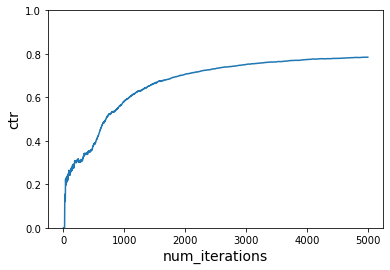

In [13]:
# FIRST SCENARIO (SEE TUTORIAL)

# With Learning
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)

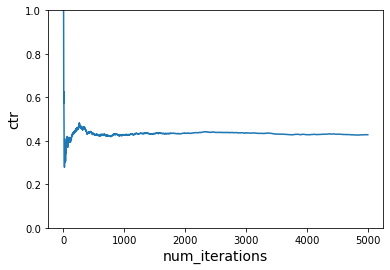

In [14]:
# we include -q UA in the arguments we supply to Vowpal Wabbit. This step tells Vowpal Wabbit to create additional features, which are the features in the (U)ser namespace and (A)ction namespaces multiplied together. Doing so allows us to learn the interaction between when specific actions are good at certain times of days and for specific users.

# If we didn’t include -q UA, the learning would not work.
# Instantiate learner in VW but without -q
vw = pyvw.vw("--cb_explore_adf --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)

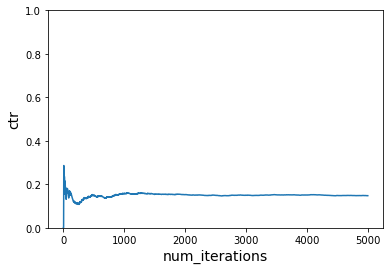

In [15]:
# Without Learning
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost, do_learn=False)

plot_ctr(num_iterations, ctr)

In [16]:
# SECOND SCENARIO (SEE TUTORIAL)

def get_cost_new1(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [17]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

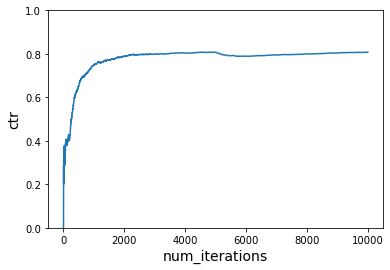

In [18]:
# With learning
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

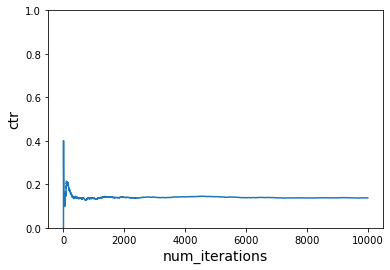

In [19]:
# Without Learning
# Do not learn
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)

plot_ctr(total_iterations, ctr)

In [20]:
# THIRD SCENARIO (SEE TUTORIAL)

def get_cost_new2(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'food':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'food':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'food':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

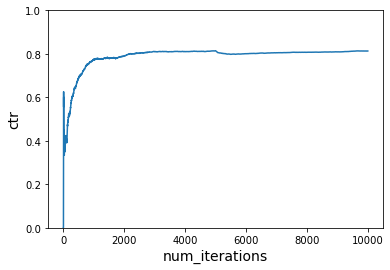

In [21]:
# use first reward function initially and then switch to third reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new2]   #  Should try [get_cost, get_cost_new1, get_cost_new2]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

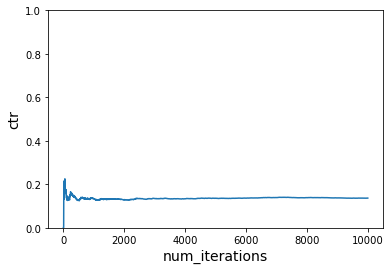

In [22]:
# Do not learn
# use first reward function initially and then switch to third reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new2]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)

plot_ctr(total_iterations, ctr)

In [23]:
# SECOND MODIFIED SCENARIO 

def get_cost_new3(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'food':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'food':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'music':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
        
def get_cost_new4(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'health':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'food':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'food':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'food':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE    
        
def get_cost_new5(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'music':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'health':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'health':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'camping':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE        
        
def get_cost_new6(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'finance':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'health':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
        
def get_cost_noise(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == random.choice(actions):
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == random.choice(actions):
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == random.choice(actions):
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == random.choice(actions):
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE        
        

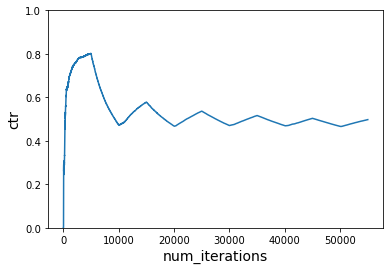

In [65]:
# use first reward function initially and then switch to second reward function and then third reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_noise,  get_cost_new1, get_cost_noise, get_cost_new3, get_cost_noise, get_cost_new4, get_cost_noise, get_cost_new5, get_cost_noise, get_cost_new6]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

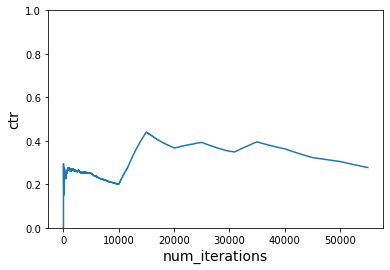

In [66]:
# use first reward function initially and then switch to second reward function and then third reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --first 7")  # Explore-first

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_noise,  get_cost_new1, get_cost_noise, get_cost_new3, get_cost_noise, get_cost_new4, get_cost_noise, get_cost_new5, get_cost_noise, get_cost_new6]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

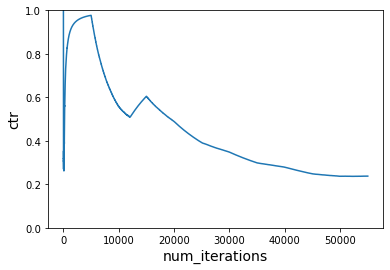

In [67]:
# use first reward function initially and then switch to second reward function and then third reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --bag 7")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_noise,  get_cost_new1, get_cost_noise, get_cost_new3, get_cost_noise, get_cost_new4, get_cost_noise, get_cost_new5, get_cost_noise, get_cost_new6]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

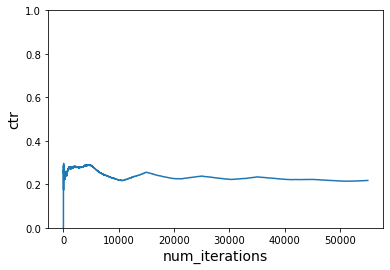

In [68]:
# use first reward function initially and then switch to second reward function and then third reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --softmax lambda 7")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_noise,  get_cost_new1, get_cost_noise, get_cost_new3, get_cost_noise, get_cost_new4, get_cost_noise, get_cost_new5, get_cost_noise, get_cost_new6]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

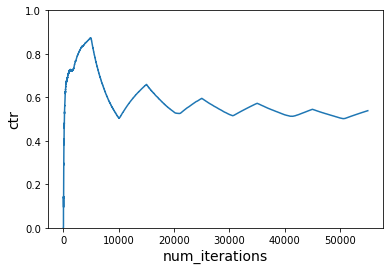

In [72]:
# use first reward function initially and then switch to second reward function and then third reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --rnd 3 --epsilon 0.02")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_noise,  get_cost_new1, get_cost_noise, get_cost_new3, get_cost_noise, get_cost_new4, get_cost_noise, get_cost_new5, get_cost_noise, get_cost_new6]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)